## Install python packages and Import libraries

!type python

pip install dynamax

In [8]:
import jax.numpy as jnp
import jax.random as jr

pip install matplotlib

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation


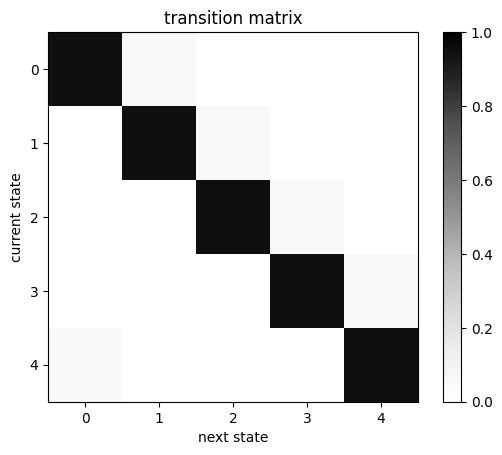

In [14]:
num_states = 5
transition_probs = (jnp.arange(num_states)**10).astype(float)
transition_probs /= transition_probs.sum()
transition_matrix = jnp.zeros((num_states, num_states))
for k, p in enumerate(transition_probs[::-1]):
    transition_matrix += jnp.roll(p * jnp.eye(num_states), k, axis=1)
    
plt.imshow(transition_matrix, vmin=0, vmax=1, cmap="Greys")
plt.xlabel("next state")
plt.ylabel("current state")
plt.title("transition matrix")
plt.colorbar()

In [16]:
print(transition_matrix.shape)

(5, 5)


In [17]:
emission_dim = 2
num_lags = 1

keys = jr.split(jr.PRNGKey(0), num_states)
angles = jnp.linspace(0, 2 * jnp.pi, num_states, endpoint=False)
theta = jnp.pi / 25 # rotational frequency
weights = jnp.array([0.8 * random_rotation(key, emission_dim, theta=theta) for key in keys])
biases = jnp.column_stack([jnp.cos(angles), jnp.sin(angles), jnp.zeros((num_states, emission_dim - 2))])
covariances = jnp.tile(0.001 * jnp.eye(emission_dim), (num_states, 1, 1))

# Compute the stationary points
stationary_points = jnp.linalg.solve(jnp.eye(emission_dim) - weights, biases)


In [18]:
keys

Array([[1524306142, 2595015335],
       [1836460763,  990488084],
       [1416732029, 1887795613],
       [1078027127, 1191019179],
       [3297765038, 3069809391]], dtype=uint32)

In [19]:
weights

Array([[[ 0.79369175,  0.10026659],
        [-0.1002666 ,  0.7936918 ]],

       [[ 0.7936918 ,  0.10026659],
        [-0.1002666 ,  0.7936918 ]],

       [[ 0.79369175,  0.10026657],
        [-0.1002666 ,  0.7936918 ]],

       [[ 0.7936918 ,  0.10026665],
        [-0.10026653,  0.7936918 ]],

       [[ 0.7936918 ,  0.10026657],
        [-0.10026661,  0.7936918 ]]], dtype=float32)

In [25]:
weights.shape

(5, 2, 2)

In [20]:
biases

Array([[ 1.        ,  0.        ],
       [ 0.30901697,  0.95105654],
       [-0.809017  ,  0.5877852 ],
       [-0.80901694, -0.58778536],
       [ 0.30901712, -0.9510565 ]], dtype=float32)

In [26]:
biases.shape

(5, 2)

In [21]:
covariances

Array([[[0.001, 0.   ],
        [0.   , 0.001]],

       [[0.001, 0.   ],
        [0.   , 0.001]],

       [[0.001, 0.   ],
        [0.   , 0.001]],

       [[0.001, 0.   ],
        [0.   , 0.001]],

       [[0.001, 0.   ],
        [0.   , 0.001]]], dtype=float32)

In [27]:
covariances.shape

(5, 2, 2)

In [23]:
stationary_points

Array([[ 3.9209812, -1.9056123],
       [ 3.0239954,  3.140209 ],
       [-2.05205  ,  3.8463686],
       [-4.292233 , -0.7630239],
       [-0.6006943, -4.3179426]], dtype=float32)

In [24]:
# Make an Autoregressive (AR) HMM
true_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
true_params, _ = true_arhmm.initialize(initial_probs=jnp.ones(num_states) / num_states,
                                       transition_matrix=transition_matrix,
                                       emission_weights=weights,
                                       emission_biases=biases,
                                       emission_covariances=covariances)

time_bins = 10000
true_states, emissions = true_arhmm.sample(true_params, jr.PRNGKey(0), time_bins)

# Compute the lagged emissions (aka inputs)
inputs = true_arhmm.compute_inputs(emissions)

In [31]:
true_params

ParamsLinearAutoregressiveHMM(initial=ParamsStandardHMMInitialState(probs=Array([0.2, 0.2, 0.2, 0.2, 0.2], dtype=float32)), transitions=ParamsStandardHMMTransitions(transition_matrix=Array([[9.4581336e-01, 5.3262077e-02, 9.2364586e-04, 9.0199791e-07,
        0.0000000e+00],
       [0.0000000e+00, 9.4581336e-01, 5.3262077e-02, 9.2364586e-04,
        9.0199791e-07],
       [9.0199791e-07, 0.0000000e+00, 9.4581336e-01, 5.3262077e-02,
        9.2364586e-04],
       [9.2364586e-04, 9.0199791e-07, 0.0000000e+00, 9.4581336e-01,
        5.3262077e-02],
       [5.3262077e-02, 9.2364586e-04, 9.0199791e-07, 0.0000000e+00,
        9.4581336e-01]], dtype=float32)), emissions=ParamsLinearRegressionHMMEmissions(weights=Array([[[ 0.79369175,  0.10026659],
        [-0.1002666 ,  0.7936918 ]],

       [[ 0.7936918 ,  0.10026659],
        [-0.1002666 ,  0.7936918 ]],

       [[ 0.79369175,  0.10026657],
        [-0.1002666 ,  0.7936918 ]],

       [[ 0.7936918 ,  0.10026665],
        [-0.10026653,  0.793

In [32]:
true_states[0]

Array(2, dtype=int32)

In [33]:
emissions[0]

Array([-0.7690557,  0.5864475], dtype=float32)

In [34]:
inputs

Array([[ 0.        ,  0.        ],
       [-0.7690557 ,  0.5864475 ],
       [-1.3324498 ,  1.1148314 ],
       ...,
       [ 0.4610385 ,  2.3752773 ],
       [-0.18958817,  2.410761  ],
       [-0.71763384,  2.5379286 ]], dtype=float32)

In [41]:
(emissions[true_states==2].T).shape

(2, 2159)

In [43]:
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink"
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)


Text(0, 0.5, '$x_2$')

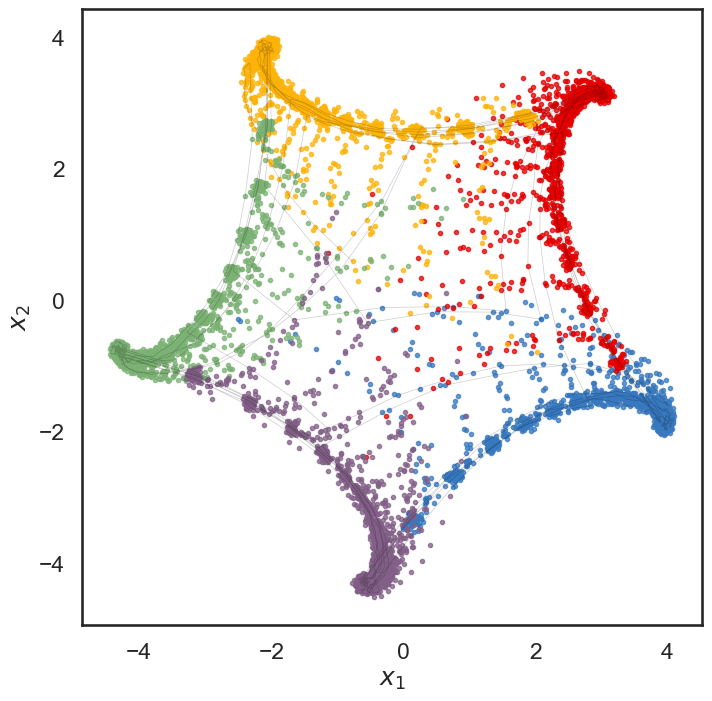

In [44]:
fig = plt.figure(figsize=(8, 8))
for k in range(num_states):
    plt.plot(*emissions[true_states==k].T, 'o', color=colors[k],
         alpha=0.75, markersize=3)
    
plt.plot(*emissions[:1000].T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

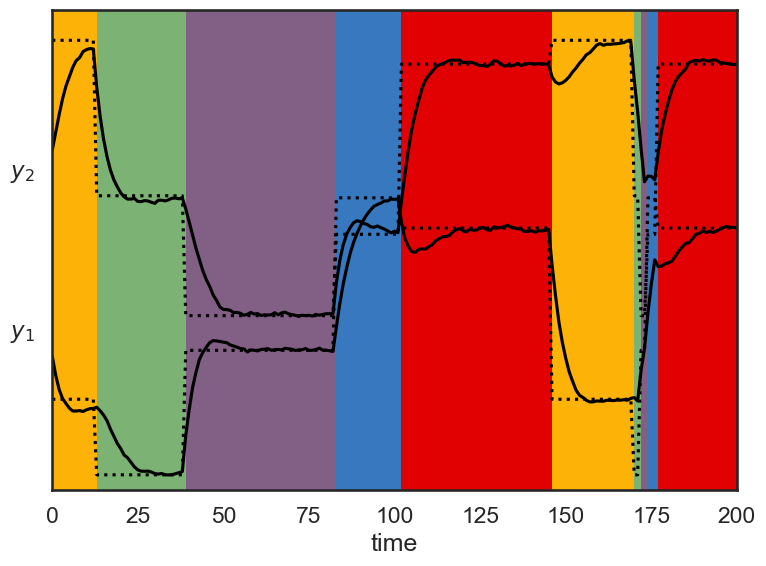

In [45]:
# Plot the emissions and the smoothed emissions
plot_slice = (0, 200)
lim = 1.05 * abs(emissions).max()
plt.figure(figsize=(8, 6))
plt.imshow(true_states[None, :],
           aspect="auto",
           cmap=cmap,
           vmin=0,
           vmax=len(colors)-1,
           extent=(0, time_bins, -lim, (emission_dim)*lim))


Ey = jnp.array(stationary_points)[true_states]
for d in range(emission_dim):
    plt.plot(emissions[:,d] + lim * d, '-k')
    plt.plot(Ey[:,d] + lim * d, ':k')

plt.xlim(plot_slice)
plt.xlabel("time")
plt.yticks(lim * jnp.arange(emission_dim), ["$y_{{{}}}$".format(d+1) for d in range(emission_dim)])

plt.tight_layout()

In [46]:
# Now fit an HMM to the emissions
key1, key2 = jr.split(jr.PRNGKey(0), 2)

test_num_states = num_states

# Initialize with K-Means
arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
params, props = arhmm.initialize(key=jr.PRNGKey(1), method="kmeans", emissions=emissions)

# Fit with EM
fitted_params, lps = arhmm.fit_em(params, props, emissions, inputs=inputs)

/Users/debrup/miniconda3/envs/def/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [47]:
key1

Array([4146024105,  967050713], dtype=uint32)

In [48]:
key2

Array([2718843009, 1272950319], dtype=uint32)

In [49]:
params

ParamsLinearAutoregressiveHMM(initial=ParamsStandardHMMInitialState(probs=Array([0.23839088, 0.00584117, 0.02619118, 0.5349991 , 0.19457771],      dtype=float32)), transitions=ParamsStandardHMMTransitions(transition_matrix=Array([[0.29667115, 0.44347057, 0.03142937, 0.02725823, 0.20117061],
       [0.09325846, 0.0989024 , 0.23276314, 0.38991886, 0.18515706],
       [0.33464482, 0.31637537, 0.14657724, 0.00078147, 0.20162117],
       [0.1484463 , 0.08116399, 0.12158427, 0.17125319, 0.4775523 ],
       [0.2818198 , 0.2430614 , 0.25977653, 0.19578186, 0.01956046]],      dtype=float32)), emissions=ParamsLinearRegressionHMMEmissions(weights=Array([[[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]]], dtype=float32), biases=Array([[-1.8018377 ,  3.279794  ],
       [-0.45280653, -3.7170458 ],
       [ 2.5164447 ,  2.7412763 ],
       [-3.628735  , -0.6924687 ],
   

In [50]:
props

ParamsLinearAutoregressiveHMM(initial=ParamsStandardHMMInitialState(probs=<dynamax.parameters.ParameterProperties object at 0x29805d610>), transitions=ParamsStandardHMMTransitions(transition_matrix=<dynamax.parameters.ParameterProperties object at 0x29c3131d0>), emissions=ParamsLinearRegressionHMMEmissions(weights=<dynamax.parameters.ParameterProperties object at 0x287996510>, biases=<dynamax.parameters.ParameterProperties object at 0x2980ec050>, covs=<dynamax.parameters.ParameterProperties object at 0x2a00fd110>))

In [51]:
fitted_params

ParamsLinearAutoregressiveHMM(initial=ParamsStandardHMMInitialState(probs=Array([0.7333336 , 0.06666671, 0.06666671, 0.06666671, 0.06666671],      dtype=float32)), transitions=ParamsStandardHMMTransitions(transition_matrix=Array([[9.4977975e-01, 4.6328470e-05, 4.6328470e-05, 5.0081063e-02,
        4.6328470e-05],
       [4.7835456e-05, 9.4910306e-01, 1.0045443e-03, 4.7835456e-05,
        4.9796700e-02],
       [5.1617604e-02, 4.8649970e-05, 9.4823629e-01, 4.8649970e-05,
        4.8649970e-05],
       [5.0263898e-05, 5.3329982e-02, 5.0263898e-05, 9.4551396e-01,
        1.0555416e-03],
       [1.2298682e-03, 5.8565169e-05, 6.0966324e-02, 5.8565169e-05,
        9.3768668e-01]], dtype=float32)), emissions=ParamsLinearRegressionHMMEmissions(weights=Array([[[ 0.7934874 ,  0.10139044],
        [-0.10105391,  0.7912106 ]],

       [[ 0.7947238 ,  0.10049167],
        [-0.10091331,  0.79297376]],

       [[ 0.7927007 ,  0.10028814],
        [-0.10240193,  0.79375434]],

       [[ 0.7929214 ,  0

In [52]:
lps

Array([-43936.656,   8983.603,  29912.23 ,  38492.426,  38492.44 ,
        38492.44 ,  38492.44 ,  38492.44 ,  38492.44 ,  38492.44 ,
        38492.44 ,  38492.44 ,  38492.44 ,  38492.44 ,  38492.44 ,
        38492.44 ,  38492.44 ,  38492.44 ,  38492.44 ,  38492.44 ,
        38492.44 ,  38492.44 ,  38492.44 ,  38492.44 ,  38492.44 ,
        38492.44 ,  38492.44 ,  38492.44 ,  38492.44 ,  38492.44 ,
        38492.44 ,  38492.44 ,  38492.44 ,  38492.44 ,  38492.44 ,
        38492.44 ,  38492.44 ,  38492.44 ,  38492.44 ,  38492.44 ,
        38492.44 ,  38492.44 ,  38492.44 ,  38492.44 ,  38492.44 ,
        38492.44 ,  38492.44 ,  38492.44 ,  38492.44 ,  38492.44 ],      dtype=float32)

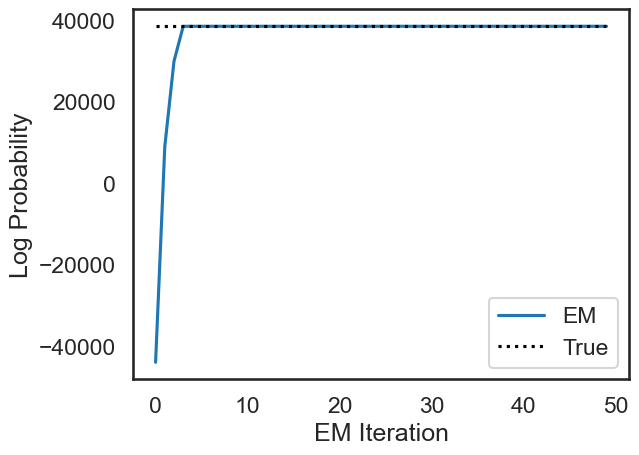

In [53]:
true_lp = true_arhmm.marginal_log_prob(true_params, emissions, inputs=inputs)
plt.plot(lps, label="EM")
plt.plot(true_lp * jnp.ones(len(lps)), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

In [54]:
posterior = arhmm.smoother(fitted_params, emissions, inputs=inputs)
most_likely_states = arhmm.most_likely_states(fitted_params, emissions, inputs=inputs)

In [55]:
posterior

HMMPosterior(marginal_loglik=Array(38483.746, dtype=float32), filtered_probs=Array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32), predicted_probs=Array([[7.3333359e-01, 6.6666707e-02, 6.6666707e-02, 6.6666707e-02,
        6.6666707e-02],
       [9.4977975e-01, 4.6328470e-05, 4.6328470e-05, 5.0081063e-02,
        4.6328470e-05],
       [9.4977975e-01, 4.6328470e-05, 4.6328470e-05, 5.0081063e-02,
        4.6328470e-05],
       ...,
       [9.4977975e-01, 4.6328470e-05, 4.6328470e-05, 5.0081063e-02,
        4.6328470e-05],
       [9.4977975e-01, 4.6328470e-05, 4.6328470e-05, 5.0081063e-02,
        4.6328470e-05],
       [9.4977975e-01, 4.6328470e-05, 4.6328470e-05, 5.0081063e-02,
        4.6328470e-05]], dtype=float32), smoothed_probs=Array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1

In [56]:
most_likely_states

Array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

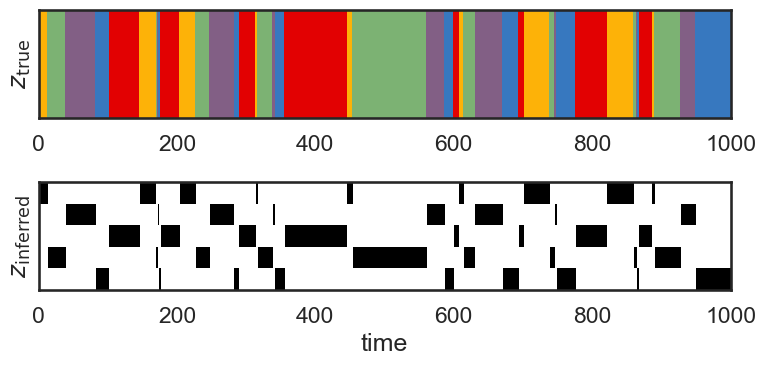

In [57]:
plot_slice = (0, 1000)
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(true_states[None,num_lags:], aspect="auto", interpolation="none", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
plt.imshow(posterior.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()


In [58]:
sampled_states, sampled_emissions = arhmm.sample(fitted_params, jr.PRNGKey(0), time_bins)


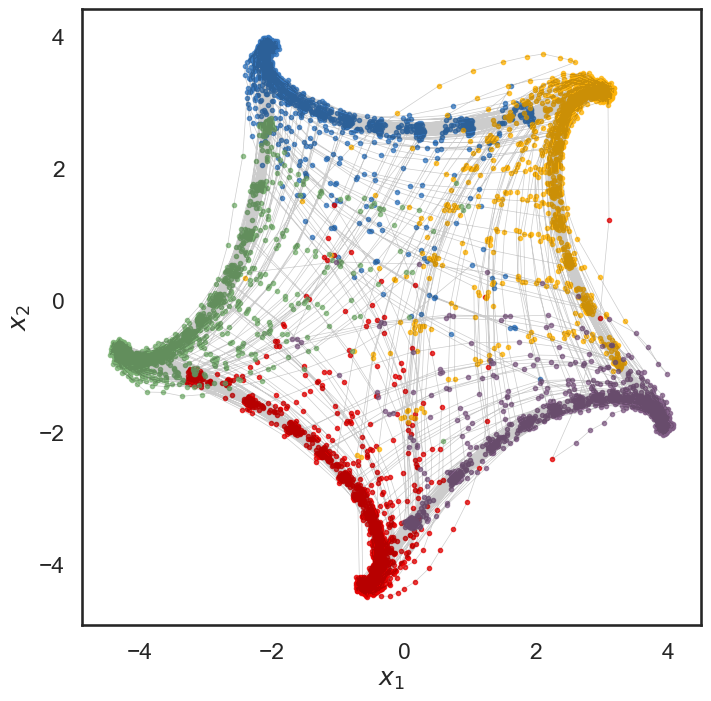

In [59]:
fig = plt.figure(figsize=(8, 8))
for k in range(test_num_states):
    plt.plot(*sampled_emissions[sampled_states==k].T, 'o', color=colors[k % len(colors)],
         alpha=0.75, markersize=3)
    
plt.plot(*sampled_emissions.T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.gca().set_aspect("equal")